In [1]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [2]:
import keras
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn import preprocessing

from cataclop.ml import preprocessing as cataclop_preprocessing

In [3]:
from cataclop.ml.pipeline import factories

dataset = factories.Dataset.factory('default', params={
    "from": "2018-01-01",
    "to": "2019-12-31",
    "countries": ["FRA"]
})
dataset.load(force=True)

22731 races


In [4]:
race_features = ['prize', 'declared_player_count']
race_features += ['odds_{:d}'.format(i) for i in range(10)]


horse_features = ['age', 'final_odds_ref', 'final_odds_ref_r'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

for f in dataset.agg_features:
        if f.startswith('final_odds'):
            continue
        horse_features.append(f)
        horse_features.append('{}_r'.format(f))
        horse_features.append('{}_std'.format(f))
        horse_features.append('{}_mean'.format(f))
        #for s in dataset.agg_features_funcs:
            #features.append('{}_{}'.format(f, s[0]))

horse_cat_features = ['horse_sex', 'horse_breed']
race_cat_features = ['sub_category']#['category', 'sub_category']

race_features = sorted(list(set(race_features)))
horse_features = sorted(list(set(horse_features)))
horse_cat_features = sorted(list(set(horse_cat_features)))
race_cat_features = sorted(list(set(race_cat_features)))

features = race_features + horse_features
cat_features = race_cat_features + horse_cat_features

print(features)
print(cat_features)


['declared_player_count', 'odds_0', 'odds_1', 'odds_2', 'odds_3', 'odds_4', 'odds_5', 'odds_6', 'odds_7', 'odds_8', 'odds_9', 'prize', 'age', 'final_odds_ref', 'final_odds_ref_r', 'handicap_distance', 'handicap_distance_mean', 'handicap_distance_r', 'handicap_distance_std', 'handicap_weight', 'handicap_weight_mean', 'handicap_weight_r', 'handicap_weight_std', 'hist_1_days', 'hist_1_days_mean', 'hist_1_days_r', 'hist_1_days_std', 'hist_1_pos', 'hist_1_pos_mean', 'hist_1_pos_r', 'hist_1_pos_std', 'hist_2_days', 'hist_2_days_mean', 'hist_2_days_r', 'hist_2_days_std', 'hist_2_pos', 'hist_2_pos_mean', 'hist_2_pos_r', 'hist_2_pos_std', 'hist_3_days', 'hist_3_days_mean', 'hist_3_days_r', 'hist_3_days_std', 'hist_3_pos', 'hist_3_pos_mean', 'hist_3_pos_r', 'hist_3_pos_std', 'hist_4_pos', 'hist_5_pos', 'hist_6_pos', 'placed_2_count', 'placed_2_count_mean', 'placed_2_count_r', 'placed_2_count_std', 'placed_3_count', 'placed_3_count_mean', 'placed_3_count_r', 'placed_3_count_std', 'placed_earnings

In [5]:
NAN_FLAG = 0

df = dataset.players.copy()
#df = df.groupby('race_id').filter(lambda r: (r['trueskill_mu'] == 25).sum() < r['declared_player_count'].max()/2 and r['position'].min() == 1 and r['winner_dividend'].max() > 0 and r['odds_0'].min() != dataset.params['nan_flag'] and r['odds_1'].min() != dataset.params['nan_flag'] )
df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1 and r['winner_dividend'].max() > 0 and r['odds_0'].min() != dataset.params['nan_flag'] and r['odds_1'].min() != dataset.params['nan_flag'] )
df.reset_index(inplace=True)
df.loc[:, features] = df.loc[:, features].fillna(NAN_FLAG)

df['position'] = df['position'].fillna(20)

scaler = preprocessing.RobustScaler() 
scaled = scaler.fit_transform(df.loc[:, features].values)

df['final_odds_ref_real'] = df['final_odds_ref'].copy()
df['declared_player_count_real'] = df['declared_player_count'].copy()
df['prize_real'] = df['prize'].copy()
df.loc[:, features] = scaled

In [6]:
horse_dummies = cataclop_preprocessing.get_dummies(df, horse_cat_features, limit=5)

df_horse_dummies = cataclop_preprocessing.get_dummy_values(df, horse_dummies)

df = pd.concat([df, df_horse_dummies], axis=1)

race_dummies = cataclop_preprocessing.get_dummies(df, race_cat_features, limit=5)

df_race_dummies = cataclop_preprocessing.get_dummy_values(df, race_dummies)

df = pd.concat([df, df_race_dummies], axis=1)


all_horse_features = list(set(horse_features + list(df_horse_dummies.columns)))

all_race_features = list(set(race_features + list(df_race_dummies.columns)))

print(len(all_horse_features), all_horse_features)
print(len(all_race_features), all_race_features)

96 ['hist_3_days_r', 'trueskill_sigma_std', 'final_odds_ref', 'hist_1_pos_mean', 'trueskill_mu_r', 'handicap_weight_mean', 'victory_earnings', 'horse_sex_value_TROTTEUR ETRANGER', 'handicap_distance_mean', 'horse_sex_value_PUR-SANG', 'hist_3_days_mean', 'hist_5_pos', 'handicap_weight_r', 'trueskill_mu', 'placed_earnings', 'hist_1_days_r', 'placed_2_count_r', 'race_count_std', 'trainer_winning_rate_mean', 'horse_breed_value_TROTTEUR ETRANGER', 'trainer_winning_rate_r', 'placed_3_count', 'hist_4_pos', 'horse_breed_value_ARABE', 'placed_earnings_r', 'hist_2_days', 'hist_2_pos', 'hist_2_pos_r', 'trainer_winning_rate_std', 'prev_year_earnings', 'hist_2_days_mean', 'hist_1_days_mean', 'hist_2_pos_mean', 'final_odds_ref_r', 'hist_6_pos', 'hist_1_days_std', 'trueskill_sigma', 'hist_3_pos_mean', 'horse_breed_value_AQPS', 'placed_earnings_mean', 'trainer_avg_winning_dividend_mean', 'race_count', 'placed_2_count_std', 'handicap_weight', 'trainer_avg_winning_dividend', 'horse_sex_value_TROTTEUR FR

In [232]:

def make_Xy(df, train=True):

    races = df.groupby('race_id')
    n_races = len(races)

    n_features = len(features)
    X = []
    y = []

    # keep track of the raw data position in the dataset 
    back_idx = []

    for race_id, race in tqdm(races, total=n_races):
        n_players = len(race)


        for i in range(n_players):
            player1 = race.iloc[i]
            x1 = player1[all_horse_features].values

            # only train on 4 first
            if train and (player1['position'] == 0 or player1['position'] > 6 ):
                continue
                
            c = player1['declared_player_count_real']

            for j in range(n_players):
                if j == i:
                    continue
                player2 = race.iloc[j]

                # only train on 4 first
                if train and (player2['position'] == 0 or player2['position'] > 6):
                    continue

                x2 = player2[all_horse_features].values

                row_x = np.concatenate((x1, x2, player1[all_race_features]))
                
                if not train:
                    row_y = 0
                else:
                
                    if c == 0:
                        continue
                        
                    p = (player2['placed_dividend'] - player1['placed_dividend']) / 100
                
                    row_y = p

                X.append(row_x)
                y.append(row_y)

                back_idx.append((race.index[i], race.index[j]))

    X = np.array(X)
    X = X.astype(np.float32)

    y = np.array(y)
    y = y.astype(np.float32)
                
    return (X, y, back_idx)
    

In [8]:
race_ids = df['race_id'].unique()
test_portion = int(len(race_ids) * 0.2)
test_race_ids = race_ids[0:test_portion]
train_race_ids = race_ids[test_portion+1:]

df_train = df[df['race_id'].isin(train_race_ids)].copy()
df_test = df[df['race_id'].isin(test_race_ids)].copy()

In [9]:
#df_train = df
df_train

In [10]:
print(len(test_race_ids), len(train_race_ids))

4472 17888


In [156]:
X = df_train[all_horse_features + all_race_features]
y = df_train['position'].fillna(df_train['declared_player_count_real']) / df_train['declared_player_count_real']

In [155]:
df_train['declared_player_count_real'].describe()

count    226253.000000
mean         13.507149
std           3.059823
min           3.000000
25%          11.000000
50%          14.000000
75%          16.000000
max          20.000000
Name: declared_player_count_real, dtype: float64

In [233]:
X, y, _ = make_Xy(df_train)

In [234]:
X.shape

(527710, 209)

<AxesSubplot:>

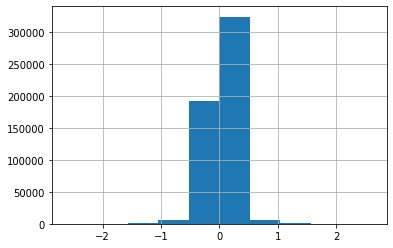

In [285]:
#y = y / 20
pd.Series(y).hist()

In [289]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
#X = np.reshape(X, (X.shape[0], X.shape[1]))

In [291]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()

'''
model.add(Dense(100, input_dim=X.shape[1]))
model.add(Dropout(0.1))
model.add(Activation('sigmoid'))
'''


model.add(Conv1D(12, 9, input_shape=(X.shape[1], 1)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

#model.add(Dense(1))
#model.add(Activation('sigmoid'))
#model.add(Dropout(0.3))


model.add(Dense(1))
model.add(Activation('tanh'))



model.compile(loss='mean_squared_error',
      optimizer='rmsprop',
      metrics=['mean_squared_error'])
          

In [287]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 201, 12)           120       
_________________________________________________________________
activation_18 (Activation)   (None, 201, 12)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 12)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 32)            1184      
_________________________________________________________________
activation_19 (Activation)   (None, 98, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 47, 64)           

In [283]:
y

array([0.215, 0.   , 0.   , ..., 0.   , 0.055, 0.   ], dtype=float32)

In [292]:
checkpointer = ModelCheckpoint(filepath='/tmp/weights.best.hdf5', 
                        verbose=1, save_best_only=True)
model.fit(X, y, 
    batch_size=32, epochs=5, validation_split=0.1, callbacks=[checkpointer])

Epoch 1/5
14841/14842 [============================>.] - ETA: 0s - loss: 0.7839 - mean_squared_error: 0.7839
Epoch 00001: val_loss improved from inf to 0.70692, saving model to /tmp/weights.best.hdf5
14842/14842 [==============================] - 315s 21ms/step - loss: 0.7839 - mean_squared_error: 0.7839 - val_loss: 0.7069 - val_mean_squared_error: 0.7069
Epoch 2/5
14840/14842 [============================>.] - ETA: 0s - loss: 0.7453 - mean_squared_error: 0.7453
Epoch 00002: val_loss improved from 0.70692 to 0.70665, saving model to /tmp/weights.best.hdf5
14842/14842 [==============================] - 279s 19ms/step - loss: 0.7453 - mean_squared_error: 0.7453 - val_loss: 0.7067 - val_mean_squared_error: 0.7067
Epoch 3/5
14840/14842 [============================>.] - ETA: 0s - loss: 0.7445 - mean_squared_error: 0.7445
Epoch 00003: val_loss improved from 0.70665 to 0.70617, saving model to /tmp/weights.best.hdf5
14842/14842 [==============================] - 230s 15ms/step - loss: 0.7445

In [20]:
from dill import dump, load
#dump(model.get_weights(), open('/tmp/weights.pkl', 'wb'))
model.save('/tmp/model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/model/assets


In [181]:
model.load_weights('/tmp/weights.best.hdf5')

In [293]:
X_test, y_test, back_idx = make_Xy(df_test, train=False)

In [75]:
X_test = df_test[all_horse_features + all_race_features]
y_test = df_test['winner_dividend'] / 1000

In [294]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

In [295]:
predictions = model.predict(X_test)

In [219]:
predictions

array([[0.83884001],
       [0.84609176],
       [0.52380711],
       ...,
       [0.68641626],
       [0.77197458],
       [0.63577547]])

In [325]:
#df_test['score'] = 0
df_test['pn'] = 0
df_test['pn_diff'] = 0
df_test['pn_same'] = 0
df_test['stash'] = 0

In [297]:

for i in tqdm(range(len(predictions))):
    
    df_test.loc[ back_idx[i][0], 'score' ] = df_test.loc[ back_idx[i][0], 'score' ] + predictions[i]


In [222]:
df_test['score'] = predictions

In [298]:
df_test['score'].describe()

count    53873.000000
mean        -3.613657
std          8.351550
min        -19.000000
25%        -10.000000
50%         -3.000000
75%          0.000000
max         19.000000
Name: score, dtype: float64

In [344]:
from cataclop.ml.exploration import random_race

random_race(df_test, ['position', 'sub_category', 'num', 'final_odds', 'final_odds_ref_real', 'score', 'pn']).sort_values(by='score')

position     sub_category  num  final_odds  final_odds_ref_real  \
race_id                                                                         
21654   3265       2.0  HANDICAP_DIVISE    9        11.7                 13.3   
        3272      20.0  HANDICAP_DIVISE   16        15.9                 16.8   
        3267      10.0  HANDICAP_DIVISE   11        15.5                 16.5   
        3258      14.0  HANDICAP_DIVISE    2        73.1                 43.8   
        3271       7.0  HANDICAP_DIVISE   15        20.2                 18.4   
        3270       6.0  HANDICAP_DIVISE   14        25.1                 31.4   
        3264       8.0  HANDICAP_DIVISE    8        30.5                 35.7   
        3262       9.0  HANDICAP_DIVISE    6         3.6                  5.4   
        3268      12.0  HANDICAP_DIVISE   12         8.5                  8.4   
        3259      11.0  HANDICAP_DIVISE    3        19.3                 18.7   
        3260       4.0  HANDICAP_DIVISE    4        10.2                  9.6   
        3269      13.0  HANDICAP_DIVISE   13        52.9                 39.0   
        3266       5.0  HANDICAP_DIVISE   10        17.6                 17.3   
        3257       1.0  HANDICAP_DIVISE    1         7.8                  6.9   
        3261       3.0  HANDICAP_DIVISE    5         7.5                  4.9   
        3263      20.0  HANDICAP_DIVISE    7         NaN             100000.0   

                 score  pn  
race_id                     
21654   3265 -1.226780   0  
        3272 -1.001847   1  
        3267 -0.965113   2  
        3258 -0.952336   3  
        3271 -0.927595   4  
        3270 -0.867839   5  
        3264 -0.861370   6  
        3262 -0.852198   7  
        3268 -0.835616   8  
        3259 -0.828972   9  
        3260 -0.825234  10  
        3269 -0.785626  11  
        3266 -0.739072  12  
        3257 -0.701427  13  
        3261 -0.620422  14  
        3263 -0.135792  15

In [328]:
def fast_bet(r):
    p = 'score'

    s = r.sort_values(by=p, ascending=True)
    o = s.index.sort_values(ascending=True, return_indexer=True)
    l = len(s)
    
    if not l:
        return r
    
    i = 0
    n = 0
    last_score = -1000
    while(i < l):
        h_score = s.iloc[i]['score']
        if last_score != h_score:
            n = n + 1
        r['pn_same'] = (s['score'] == h_score).sum() / l
        i = i + 1
        
    #idx = (r[p] == r[p].max())
    
    s2 = r.sort_values(by='final_odds_ref')
    o2 = s2.index.sort_values(ascending=True, return_indexer=True)
    
    s3 = r.sort_values(by='final_odds')
    o3 = s3.index.sort_values(ascending=True, return_indexer=True)
        
    r['pn'] = o[1]
    r['oddsrn'] = o2[1]
    r['oddsn'] = o3[1]
    r['pstd'] = r[p].std()
    r['pn_diff'] = n
    return r

In [329]:
df_test = df_test.groupby('race_id').apply(fast_bet)

In [354]:
df_test['bet'] = 1#+df_test['pn']#df_test['oddsn']#np.clip(df_test['oddsn'] + 1, 1, 3) #1 #/ np.clip(df_test['score'], 0, 10)
df_test['profit'] = df_test['bet'] * (df_test['winner_dividend'].fillna(0.)/100.-1.0)# + (df_test['winner_dividend'].fillna(0.)/100.-1.0)

In [352]:
h = df_test

print('win % for pred number #')
for i in range(20):
    if len(h[ (h['pn']==i) & (h['position'] > 3)]):
        print(i, len(h[ (h['pn']==i) & (h['position'] == 1)]) / len(h[ (h['pn']==i) & (h['position'] != 1)]))
        print('  $$ ',  h[ (h['pn']==i) ]['profit'].mean() )
    
print('win % for odds ref number #')
for i in range(10):
    if len(h[ (h['oddsrn']==i) & (h['position'] > 3)]):
        print(i, len(h[ (h['oddsrn']==i) & (h['position'] == 1)]) / len(h[ (h['oddsrn']==i) & (h['position'] != 1)]))
        print('$$ ',  h[ (h['oddsrn']==i) ]['profit'].mean() )

print('win % for pred number #, when odds number >')
for i in range(10):
    if len(h[ (h['pn']==i) & (h['oddsn']<i) & (h['position'] > 3)]):
        print(i, len(h[ (h['pn']==i) & (h['oddsn']>i) & (h['position'] == 1)]) / len(h[ (h['pn']==i) & (h['oddsn']>i) & (h['position'] != 1)]))
        print('$$ ', h[ (h['pn']==i) & (h['oddsn']>i)]['profit'].mean() )

win % for pred number #
0 0.09500489715964741
  $$  -0.28407871198568874
1 0.10501606127996047
  $$  -0.45939177101967804
2 0.09420112551994128
  $$  -0.8449910554561717
3 0.08596406022340942
  $$  -1.322898032200358
4 0.09470068694798822
  $$  -1.4782608695652173
5 0.0939830929885629
  $$  -1.7436818181818183
6 0.10495932826029913
  $$  -0.4415103300878652
7 0.09620182977543665
  $$  -1.7448659585230148
8 0.09035962526443034
  $$  -2.0092849223946785
9 0.08514190317195326
  $$  -3.094153846153846
10 0.08311195445920304
  $$  -3.254905395935529
11 0.08532272325375774
  $$  -1.985498981670061
12 0.07422895974908521
  $$  -3.896204379562043
13 0.07677784770295784
  $$  -4.796493278784336
14 0.06904761904761905
  $$  -3.242761692650334
15 0.06754032258064516
  $$  -4.602077431539188
16 0.06497175141242938
  $$  -1.7270557029177716
17 0.0380952380952381
  $$  -4.054128440366973
18 0.0
  $$  -19.0
19 0.0
  $$  -20.0
win % for odds ref number #
0 0.3983739837398374
$$  -1.2012969588550986
1 

In [268]:
print(df_test['start_at'].min(), df_test['start_at'].max())
print(df_train['start_at'].min(), df_train['start_at'].max())

2018-01-06 11:50:00 2019-12-23 16:14:00
2018-01-01 12:52:00 2019-12-30 20:33:00


In [357]:
#g = df_test[(df_test['sub_category']=='HANDICAP') & (df_test['oddsrn'] <= df_test['pn']) & (df_test['final_odds_ref'] < 30.) & (df_test['final_odds_ref'] > 1.)].copy()
#df_test[(df_test['pn']==0) & (df_test['pstd']<1.) & (df_test['final_odds_ref'] > 1.) & (df_test['final_odds_ref'] < 30.)]['profit'].describe()



for cat in df_test['sub_category'].value_counts().index:
    print(cat)
    
    g = df_test[ (df_test['pn_same']<0.1) & (df_test['pn']==0) & (df_test['sub_category']==cat) & (df_test['final_odds_ref_real'] > 2) & (df_test['final_odds_ref_real'] < 40) ].copy()
    print(g['profit'].describe())

COURSE_A_CONDITIONS
count    80.000000
mean     -0.727500
std       1.142058
min      -1.000000
25%      -1.000000
50%      -1.000000
75%      -1.000000
max       6.600000
Name: profit, dtype: float64
INCONNU
count    106.000000
mean      -0.040566
std        3.560358
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       26.600000
Name: profit, dtype: float64
HANDICAP_DIVISE
count    224.000000
mean      -0.258929
std        3.804330
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       35.000000
Name: profit, dtype: float64
A_RECLAMER
count    66.000000
mean     -0.412121
std       3.394861
min      -1.000000
25%      -1.000000
50%      -1.000000
75%      -1.000000
max      21.500000
Name: profit, dtype: float64
AUTOSTART
count    48.000000
mean     -0.327083
std       2.554157
min      -1.000000
25%      -1.000000
50%      -1.000000
75%      -1.000000
max      12.900000
Name: profit, dtype: float64
HANDICAP_CATEG

COURSE_A_CONDITIONS
934
               start_at        horse_name  race_id     prize  bet  oddsn  \
25  2018-01-06 12:50:00      GALATA TOWER    13639  0.354981    1      3   
170 2018-01-15 12:55:00         PLAVALINE    13983  0.417374    1      5   
223 2018-01-15 15:10:00  BEYOND MY DREAMS    13987  0.354981    1      6   
259 2018-01-15 16:12:00          ASHTANEH    13989 -0.081598    1      3   
286 2018-01-26 13:02:00    RUNNING WATERS    14425  0.077616    1      3   
336 2018-01-26 15:12:00     GOOD QUESTION    14429  0.354981    1      4   
516 2018-02-01 15:42:00       BERMONVILLE    14662  0.417374    1      5   
572 2018-02-08 12:55:00   HURRICANE LIGHT    14943  0.417374    1      6   
608 2018-02-08 14:35:00    BREATH OF LIFE    14946  0.354981    1      5   
634 2018-02-08 15:40:00         GONE SOLO    14948  0.354981    1      6   

            sub_category  final_odds  winner_dividend  placed_dividend  \
25   COURSE_A_CONDITIONS         9.4              0.0            

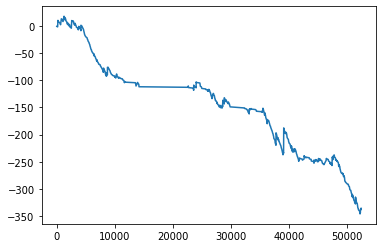

INCONNU
456
                start_at      horse_name  race_id     prize  bet  oddsn  \
2811 2018-06-17 17:30:00  RODESS DU LOUP    20311  3.205417    1      1   
6227 2019-03-25 17:17:00      THORPE BAY    69421 -0.354977    1      5   
6552 2019-04-13 13:18:00         ORKANOS    70132 -0.354977    1     10   
7468 2019-06-16 18:00:00          KANAAN    72499  3.205417    1      4   
7539 2019-06-21 15:56:00  SCRIBNER CREEK    72694 -0.354977    1      2   
7917 2019-09-20 14:17:00  MAIZE AND BLUE    76247 -0.354977    1      4   
9192 2018-05-08 12:20:00    FOREVER JIEL    18607 -0.457644    1      3   
9835 2018-09-06 15:40:00  DIAMANT D'IDEF    63320 -0.081598    1      6   
9847 2018-09-06 16:10:00    BEAU JENILOU    63321  0.645023    1      7   
9861 2018-09-09 14:30:00     FILS A PAPA    63493 -0.812614    1      2   

     sub_category  final_odds  winner_dividend  placed_dividend  position  \
2811      INCONNU         5.4            540.0            220.0       1.0   
6227    

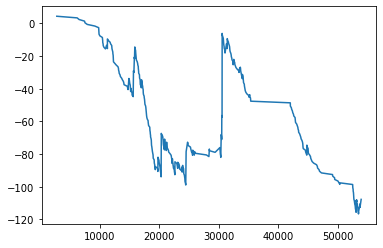

HANDICAP_DIVISE
336
               start_at    horse_name  race_id     prize  bet  oddsn  \
79  2018-01-06 14:20:00      CHAOLINI    13642 -0.354977    1      2   
103 2018-01-06 15:32:00   AS D'ARTOIS    13644 -0.081598    1      5   
118 2018-01-06 16:02:00       DYREMIS    13645 -0.167608    1      2   
163 2018-01-15 12:25:00  SOMBRE HEROS    13982 -0.258535    1      2   
201 2018-01-15 14:05:00   APRIL ANGEL    13985 -0.167608    1      7   
213 2018-01-15 14:37:00        FRESCO    13986  0.000000    1      8   
264 2018-01-26 12:32:00  SPEEDY SPEED    14424 -0.567396    1      7   
289 2018-01-26 13:32:00       DYREMIS    14426 -0.258535    1      1   
363 2018-01-26 15:45:00   ROYAL GREEN    14430 -0.258535    1      9   
375 2018-01-26 16:17:00  JACK MUSCOLO    14431 -0.081598    1     12   

        sub_category  final_odds  winner_dividend  placed_dividend  position  \
79   HANDICAP_DIVISE         7.0              0.0              0.0       4.0   
103  HANDICAP_DIVISE       

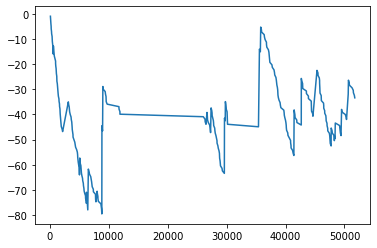

A_RECLAMER
325
                start_at      horse_name  race_id     prize  bet  oddsn  \
186  2018-01-15 13:25:00  ORIENTAL GHOST    13984 -0.457644    1      8   
418  2018-02-01 12:25:00     WORLD POWER    14656 -0.354977    1      1   
438  2018-02-01 13:00:00      BELLE CITY    14657  0.000000    1      7   
556  2018-02-08 12:25:00          AKIRIA    14942 -0.354977    1     12   
664  2018-02-13 12:25:00  QUIZ EVOLUTION    15144 -0.167608    1      4   
691  2018-02-13 13:25:00           SHILO    15146 -0.258535    1      1   
694  2018-02-13 14:05:00       MUNAASHID    15147 -0.167608    1      3   
770  2018-02-16 13:25:00    NINE OU FOUR    15263 -0.457644    1      2   
1084 2018-03-06 12:40:00       ALSSARUKH    15963  0.477412    1      6   
1364 2018-03-15 12:40:00       MUNAASHID    16325 -0.081598    1      2   

     sub_category  final_odds  winner_dividend  placed_dividend  position  \
186    A_RECLAMER        23.8              0.0              0.0       9.0   
418  

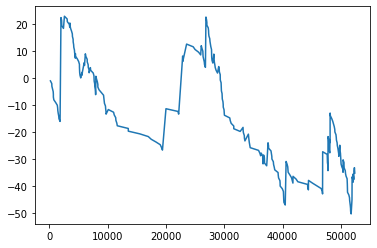

AUTOSTART
244
                 start_at          horse_name  race_id     prize  bet  oddsn  \
11950 2018-01-17 14:35:00         ETOILE ALDO    14060 -0.258535    1      1   
12014 2018-01-21 13:45:00     FANTASTIQUE ACE    66025 -0.812614    1      3   
12121 2018-01-28 17:05:00            BOYLOTIN    14529 -0.167608    1      5   
12164 2018-01-28 14:15:00  ETIKETTE DU PHENIX    66067 -0.685285    1      6   
12183 2018-01-28 14:45:00  BRASILIA DU PERCHE    66068 -0.457644    1      6   
12273 2018-02-04 13:40:00         FRENCH BABY    66097 -0.812614    1      6   
12353 2018-02-04 17:10:00     AS DES CHALIERS    66103 -0.685285    1      5   
12396 2018-02-17 13:20:00     ECLAIR DES VAUX    15301 -0.167608    1      7   
12674 2018-03-25 12:50:00      EL NINA FLIGNY    16763 -0.081598    1      6   
12765 2018-04-15 15:45:00  BRASILIA DU PERCHE    17662 -0.457644    1      8   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
11950    AUTOSTART         

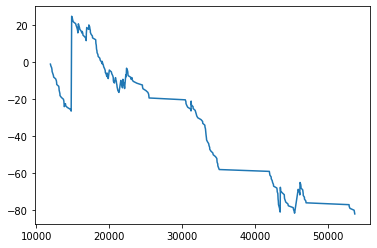

HANDICAP_CATEGORIE_DIVISE
150
                start_at          horse_name  race_id     prize  bet  oddsn  \
2043 2018-04-13 17:23:00        MOCKLERSHILL    17546 -0.812614    1      2   
2206 2018-04-27 15:00:00            SUNDERIA    18119 -0.081598    1      1   
2240 2018-04-27 16:00:00        SOMBRE HEROS    18121  0.077616    1      1   
2251 2018-04-27 16:30:00  LIGHT OF THE WORLD    18122 -0.081598    1     11   
2321 2018-05-02 15:40:00               O DEE    18357  0.077616    1     12   
2346 2018-05-02 16:14:00         BECQUAGEMME    18358 -0.081598    1      2   
2386 2018-05-07 14:50:00           ALSSARUKH    18557  0.222335    1      6   
2398 2018-05-07 15:55:00           MA LOUGIE    18559 -0.081598    1     10   
2638 2018-05-18 16:47:00              AKIRIA    19022  0.077616    1     14   
2651 2018-05-18 17:17:00            SUNDERIA    19023 -0.081598    1      9   

                   sub_category  final_odds  winner_dividend  placed_dividend  \
2043  HANDICAP_CATE

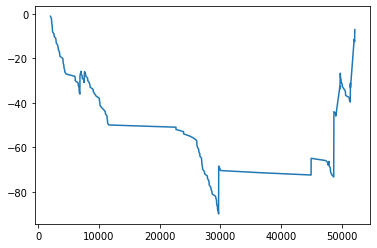

HANDICAP
110
                start_at      horse_name  race_id     prize  bet  oddsn  \
62   2018-01-06 13:50:00   LA MANDRAGOLA    13641  0.290040    1      4   
386  2018-01-26 16:47:00          FRESCO    14432  0.000000    1     10   
807  2018-02-16 14:35:00  DESERT HEIGHTS    15265  0.000000    1     10   
909  2018-02-22 14:05:00         GASALTO    15496  0.000000    1      5   
1037 2018-02-23 15:40:00     APRIL ANGEL    15541  0.000000    1     12   
1314 2018-03-13 15:00:00     ZONE REGARD    16244  0.645023    1      4   
2713 2018-06-03 16:58:00         MEZIDON    19727  1.992950    1     11   
2830 2018-06-17 18:05:00  AKINATHOR GAME    20312  1.609294    1      7   
3058 2018-11-08 13:28:00         SEXTINE    21052  1.102680    1      6   
3151 2018-11-13 12:25:00          IVIRKA    21320  1.102680    1      7   

     sub_category  final_odds  winner_dividend  placed_dividend  position  \
62       HANDICAP        12.3              0.0              0.0      16.0   
386    

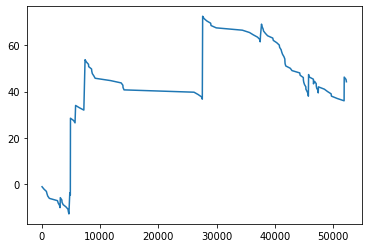

HANDICAP_DE_CATEGORIE
93
                start_at          horse_name  race_id     prize  bet  oddsn  \
1134 2018-03-06 14:50:00         SOME NIGHTS    15967  0.222335    1     13   
1491 2018-03-20 14:52:00      EN PLEIN COEUR    16543 -0.081598    1      0   
1997 2018-04-13 15:48:00     TRESOR DU ROUME    17543  0.222335    1      1   
2735 2018-06-03 18:10:00      ZIGGY STARDUST    19729  0.222335    1      5   
2747 2018-06-17 13:48:00  DOCTOR FONTENAILLE    20305  0.000000    1      1   
2770 2018-06-17 14:50:00        TEXAS RANGER    20307  0.151621    1      3   
3015 2018-11-07 16:07:00               LOMAO    21011  0.222335    1      3   
3419 2018-07-09 16:25:00   MA PETITE TOSCANE    22228  0.222335    1     15   
3629 2018-07-27 17:13:00              SAMOON    23069 -0.081598    1      6   
4447 2018-09-15 19:47:00            AN AMKAN    63735 -0.081598    1      8   

               sub_category  final_odds  winner_dividend  placed_dividend  \
1134  HANDICAP_DE_CATEGORIE 

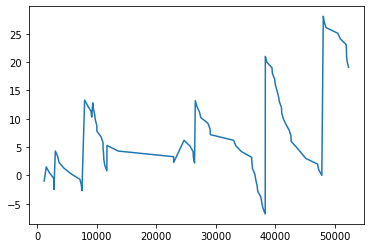

NATIONALE
73
                 start_at          horse_name  race_id     prize  bet  oddsn  \
9095  2018-04-15 11:50:00      FLECHE DE JIEL    17634 -0.354977    1      1   
9267  2018-05-08 15:30:00               DUSTY    18613  0.000000    1     11   
9748  2018-09-06 11:55:00         FORMAT D'AM    63313 -0.258535    1      2   
9761  2018-09-06 12:25:00   FLANDERS CALENDES    63314 -0.258535    1      4   
9787  2018-09-06 13:27:00      EL GATO GRANDE    63316  0.000000    1      8   
10281 2018-10-17 16:25:00        FRAGGLE ROCK    65235  0.151621    1      8   
10306 2018-10-17 16:55:00         ELTON TRAFO    65236  0.535267    1      1   
10793 2019-04-14 12:10:00     GADJO SAUTREUIL    70167 -0.457644    1      0   
11203 2019-09-05 11:50:00      GRAAL DU CHENE    75705 -0.457644    1      1   
11215 2019-09-05 12:20:00  FRIPON DE L'EPINAY    75706 -0.258535    1     10   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
9095     NATIONALE         2

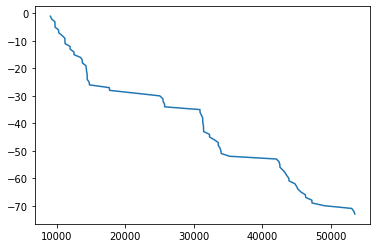

APPRENTIS_LADS_JOCKEYS
54
                 start_at          horse_name  race_id     prize  bet  oddsn  \
9807  2018-09-06 14:07:00          CARRE CHIC    63317  0.000000    1     10   
10268 2018-10-17 15:55:00          COCCINELLE    65234  0.151621    1      7   
11226 2019-09-05 12:52:00           DRIGANALA    75707 -0.258535    1      6   
12494 2018-03-04 13:15:00    DAYLIGHT OF LOVE    15897 -0.167608    1      7   
12841 2018-04-15 16:45:00                EVRY    66478 -0.567396    1      7   
13040 2018-04-25 16:00:00             CANCALE    18026  0.151621    1      7   
13314 2018-06-10 11:45:00  VOYOU DES BRUYERES    20019  0.077616    1      8   
13526 2018-06-16 21:32:00      CASTING DANCER    20295  0.000000    1      8   
14833 2019-06-15 20:30:00       ELIXIR MERITE    72482  0.077616    1      5   
15092 2018-02-23 14:21:00           DUC QUICK    15519  0.935068    1      5   

                 sub_category  final_odds  winner_dividend  placed_dividend  \
9807   APPRENT

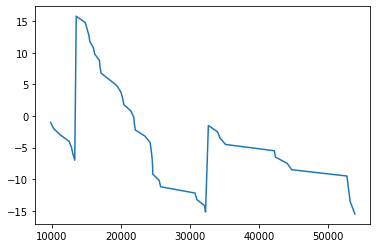

EUROPEENNE
61
                 start_at         horse_name  race_id     prize  bet  oddsn  \
10240 2018-10-17 14:52:00   ARAMIS DE DIGEON    65232  0.645023    1      9   
11256 2019-09-05 14:37:00       GUSTY RHYTHM    75710  0.222335    1      1   
12435 2018-02-17 14:52:00  THAIGER EXCLUSIVE    15304  0.151621    1      1   
12454 2018-02-17 15:32:00             BRABUS    15305  1.021080    1      3   
13026 2018-04-25 15:23:00   COLONEL CHANLECY    18025  0.354981    1      1   
14424 2019-03-20 13:45:00      DEFI DE MORGE    69229  0.747694    1      6   
14497 2019-03-20 17:15:00         BOXING DAY    69235  1.021080    1      6   
15365 2018-02-28 15:05:00      CYRIEL D'ATOM    15715  2.205380    1      3   
15646 2018-04-30 18:06:00           DASCALIA    18286  1.580103    1      6   
15664 2018-04-30 18:34:00            URBANIO    18287  1.580103    1      1   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
10240   EUROPEENNE        44.2        

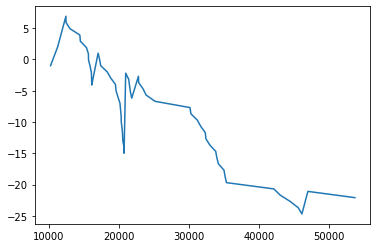

AMATEURS_AUTOSTART
52
                 start_at          horse_name  race_id     prize  bet  oddsn  \
11929 2018-01-17 13:27:00            VAQUESSO    14058 -1.915201    1      4   
12095 2018-01-21 16:30:00    VILATE DU BOCAGE    66030 -1.915201    1      5   
12420 2018-02-17 14:20:00    VICTOR DU MOULIN    15303 -1.915201    1      6   
12523 2018-03-04 13:48:00  VOYOU DES BRUYERES    15898 -1.915201    1      7   
12659 2018-03-25 12:20:00      BEAUTE D'ATOUT    16762 -1.915201    1      3   
12873 2018-04-15 17:45:00      BELLA DU BEROY    66480 -1.915201    1      5   
12895 2018-04-22 14:15:00        BELDI WINNER    66531 -3.017656    1      2   
12931 2018-04-22 15:15:00    AKITA D'OCCAGNES    66533 -1.915201    1     11   
12968 2018-04-22 17:08:00      BELLA DU BEROY    66535 -3.017656    1      0   
13295 2018-05-06 20:25:00       ALIBI DU GADE    18539 -1.915201    1      9   

             sub_category  final_odds  winner_dividend  placed_dividend  \
11929  AMATEURS_AUTOST

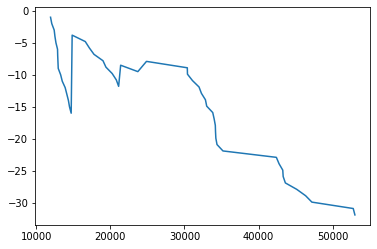

EUROPEENNE_AUTOSTART
52
                 start_at         horse_name  race_id     prize  bet  oddsn  \
12630 2018-03-18 16:30:00      DREAM STAR HM    16501 -0.457644    1     11   
12747 2018-03-25 15:30:00            ANDANTE    16768  0.354981    1      1   
14379 2019-03-03 14:54:00            BEA GYN    68622  0.354981    1      7   
14750 2019-06-15 17:19:00         AMIGO KUKY    72476  0.151621    1     10   
15332 2018-02-28 13:47:00  ALTESSE DU BANNEY    15713  1.609294    1      5   
15792 2018-05-26 15:10:00     BAXTER DU KLAU    19348  1.850389    1      1   
15904 2018-06-16 15:15:00         TAMURE ROC    20261  2.205380    1      0   
16189 2018-07-11 13:47:00        OLIMPUS CAF    22298  1.693784    1      9   
16290 2018-07-11 17:29:00      VOLTURINA JET    22305  1.457669    1      7   
16359 2018-07-15 16:15:00     ELIZIR DU HOME    22507  1.457669    1      4   

               sub_category  final_odds  winner_dividend  placed_dividend  \
12630  EUROPEENNE_AUTOSTART  

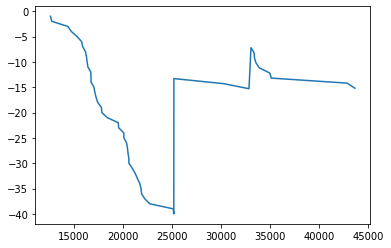

GROUPE_III
73
                start_at        horse_name  race_id    prize  bet  oddsn  \
1977 2018-04-13 14:20:00     SANDS OF MALI    17541  2.20538    1      1   
2375 2018-05-07 14:20:00  ALTERNATIVE FACT    18556  2.20538    1      5   
2726 2018-06-03 17:35:00          WALDLIED    19728  2.20538    1      2   
2763 2018-06-17 14:20:00       SUN AT WORK    20306  2.20538    1      6   
2789 2018-06-17 15:26:00       WIND CHIMES    20308  2.20538    1      0   
3387 2018-07-09 15:25:00         FLOWRIDER    22226  2.20538    1      2   
4200 2018-09-01 14:23:00          TUDO BEM    63065  2.20538    1      6   
6589 2019-04-13 14:54:00           BARBILL    70135  2.20538    1      0   
7056 2019-05-06 16:10:00           MAKMOUR    70956  2.20538    1      1   
7361 2019-06-02 17:50:00            SAGAMA    71995  2.20538    1      7   

     sub_category  final_odds  winner_dividend  placed_dividend  position  \
1977   GROUPE_III         4.7            470.0            200.0       1.

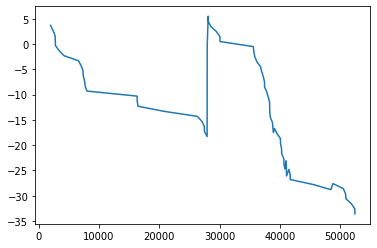

NATIONALE_AUTOSTART
61
                 start_at          horse_name  race_id     prize  bet  oddsn  \
11942 2018-01-17 14:05:00         FAIRY WHITE    14059  0.077616    1      2   
12392 2018-02-17 12:50:00         FIRST LEBEL    15300  0.000000    1      6   
12480 2018-02-17 16:34:00    DONATELLA TERRIE    15307  0.077616    1      9   
12636 2018-03-25 11:20:00    FONDON DE PELMER    16760  0.151621    1      3   
12724 2018-03-25 14:22:00  DAKARA DES VOLCANS    16766  0.000000    1     10   
12736 2018-03-25 14:51:00     DECOSTER VALLEE    16767  0.000000    1      4   
12975 2018-04-25 13:12:00     ELIXIR DU GILET    18021  0.077616    1      3   
13100 2018-04-26 13:27:00     EMILIE DES IRIS    18069  0.077616    1      4   
13192 2018-05-06 16:47:00    FLEUR DE PENGUEN    18532 -0.081598    1      5   
13504 2018-06-16 20:23:00      FULL DES LUCAS    20293  0.000000    1      5   

              sub_category  final_odds  winner_dividend  placed_dividend  \
11942  NATIONALE_AUT

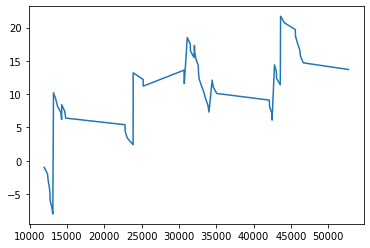

AMATEURS
33
                 start_at          horse_name  race_id     prize  bet  oddsn  \
9154  2018-04-15 14:22:00            CASTALDO    17639 -1.915201    1      6   
11462 2019-10-20 12:10:00            CASTALDO    77335 -1.915201    1      7   
12910 2018-04-22 14:45:00      COYAN D'ALSACE    66532 -3.017656    1     10   
16900 2018-07-29 20:45:00        COCKTAIL WAY    23181 -0.685285    1      1   
17003 2018-06-28 21:31:00    BRISE DU CHOQUEL    52791 -0.685285    1      0   
18884 2019-03-08 18:47:00      BIG BEN FRANCA    68799 -0.951027    1      0   
19307 2019-03-26 18:42:00           CASH VRAC    69472 -0.951027    1      9   
19641 2019-04-29 18:50:00  CHENE DE LANDISACQ    70704 -0.951027    1     10   
19993 2019-06-26 18:46:00       CALBA DU PONT    72893 -0.951027    1      7   
20071 2019-06-29 14:37:00       ALIVE BRULARD    73000 -0.951027    1     11   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
9154      AMATEURS        91.

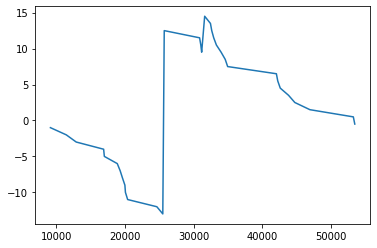

COURSE_A_CONDITION_QUALIF_HP
57
                start_at         horse_name  race_id     prize  bet  oddsn  \
1326 2018-03-13 15:40:00       PONT NEUILLY    16245 -0.167608    1      0   
1827 2018-03-31 17:23:00           SKY BOLT    16997 -0.167608    1      7   
2388 2018-05-07 15:20:00             ICONIC    18558 -0.167608    1      7   
4606 2018-10-12 16:44:00  KOOL AND THE GANG    64983  0.290040    1      8   
5923 2019-03-12 17:30:00    DUQUESA PENGUIN    68923  0.000000    1      9   
5936 2019-03-12 18:00:00             ZEPHIR    68924 -0.167608    1      9   
6313 2019-03-28 17:17:00       LAVINIA ROSE    69531 -0.167608    1     11   
6736 2019-04-24 16:29:00    DUQUESA PENGUIN    70516 -0.167608    1      1   
7202 2019-05-17 14:29:00       HAPPY ENDING    71391  0.222335    1      8   
7308 2019-06-02 13:55:00          NORTH END    71989  0.290040    1      1   

                      sub_category  final_odds  winner_dividend  \
1326  COURSE_A_CONDITION_QUALIF_HP        

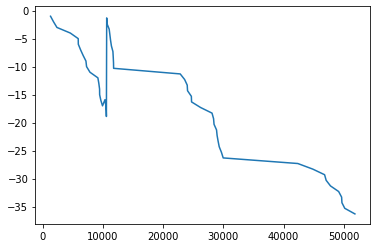

APPRENTIS_LADS_JOCKEYS_AUTOSTART
26
                 start_at          horse_name  race_id     prize  bet  oddsn  \
11895 2018-01-17 12:30:00     CRACK DU TILLET    14056  0.077616    1      1   
13674 2019-01-16 12:05:00   CALL ON ME RANAIS    61136 -0.167608    1      6   
14224 2019-02-16 13:15:00    ATHOS DU MANOLET    68092  0.222335    1      7   
15494 2018-04-19 18:18:00     CRESUS DU CHENE    17796  1.325021    1      6   
15742 2018-04-30 21:00:00      COOPER DE GUEZ    18292  1.102680    1      6   
15761 2018-05-26 14:05:00  EVERY TIME BOURBON    19346  0.935068    1      0   
18071 2018-09-27 20:00:00        BALOU DE MAI    64337  1.180298    1      0   
18352 2018-10-11 18:40:00           DIEGO NAY    64943  1.102680    1      6   
23896 2018-09-09 19:12:00   DAISY DES CHARMES    63464 -0.258535    1      8   
23909 2018-09-09 19:40:00      DESPERATE GIRL    63465 -0.258535    1      7   

                           sub_category  final_odds  winner_dividend  \
11895  APPR

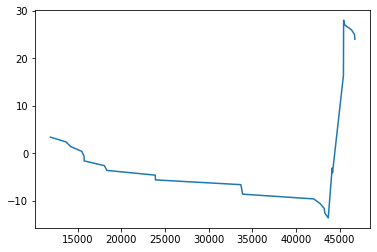

GROUPE_II
28
                 start_at          horse_name  race_id     prize  bet  oddsn  \
2670  2018-06-03 14:30:00  MISSION IMPASSIBLE    19723  2.977762    1      2   
2676  2018-06-03 15:02:00           SON CESIO    19724  2.977762    1      1   
2688  2018-06-03 15:36:00        WAY TO PARIS    19725  2.977762    1      4   
2810  2018-06-17 16:49:00            SOLESILI    20310  2.977762    1      7   
7328  2019-06-02 15:40:00               ZIYAD    71992  2.977762    1      6   
17076 2018-06-30 15:45:00    UN MEC D'HERIPRE    52851  2.850424    1      0   
17688 2018-08-11 16:35:00           AMOUR FOU    62089  2.850424    1      7   
22746 2018-04-28 17:15:00  BILLIE DE MONTFORT    18172  2.560373    1      1   
27748 2018-10-13 15:50:00      HELLO YOUMZAIN    65020  3.581483    1      4   
29836 2019-10-12 14:38:00     SPARTAN FIGHTER    77025  3.581483    1      6   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
2670     GROUPE_II         5

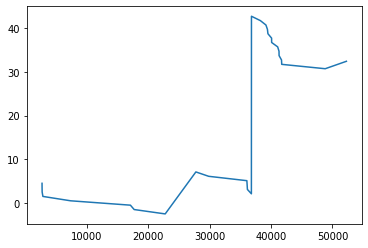

A_RECLAMER_AUTOSTART
16
                 start_at        horse_name  race_id     prize  bet  oddsn  \
15138 2018-02-23 15:57:00  EUREKA DE NAPPES    15522  0.000000    1      6   
15239 2018-02-24 19:10:00  COLIBRI DE LARRE    15587  0.000000    1      4   
15720 2018-04-30 20:33:00      ENZO MESLOIS    18291  0.000000    1      3   
16558 2018-07-25 16:27:00      DERBY WINNER    22964  0.000000    1      0   
17902 2018-08-16 12:25:00      FLASH TURGOT    62333  0.000000    1     10   
18042 2018-09-27 18:55:00    DEMON DE BABEL    64335  0.000000    1      6   
18901 2019-03-08 19:18:00           AS DORE    68800 -0.167608    1      1   
19127 2019-03-14 19:42:00  GIORDANO DU PECH    69026 -0.167608    1      3   
20044 2019-06-29 14:00:00   DIVINE EMERAUDE    72999 -0.167608    1      8   
20850 2019-07-25 22:30:00           EL TORO    74064 -0.167608    1     12   

               sub_category  final_odds  winner_dividend  placed_dividend  \
15138  A_RECLAMER_AUTOSTART        29.9 

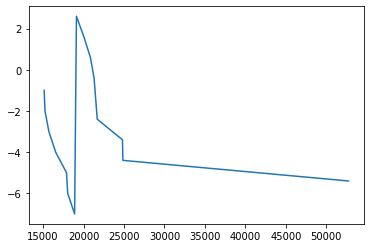

GROUPE_I
21
                 start_at    horse_name  race_id     prize  bet  oddsn  \
2695  2018-06-03 16:15:00     HEY GAMAN    19726  6.868564    1      6   
2791  2018-06-17 16:07:00       HAPPILY    20309  6.223515    1      6   
4848  2018-10-28 15:47:00  MAX DYNAMITE    65730  4.553368    1      8   
4854  2018-10-28 16:22:00      GRAIGNES    65731  4.018080    1      4   
7338  2019-06-02 16:25:00     RAISE YOU    71993  6.868564    1      5   
7412  2019-06-16 16:05:00   GRAND GLORY    72496  6.223515    1     11   
36401 2018-05-19 16:18:00     WILDRIVER    19045  4.018080    1      4   
36508 2018-05-20 17:05:00   L'AMI SERGE    19112  4.553368    1      2   
37046 2018-11-03 15:50:00     AZUCARDEL    20786  4.553368    1      1   
37113 2018-11-04 14:03:00   PORTO POLLO    20842  4.018080    1      5   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
2695      GROUPE_I        18.3              0.0              0.0       7.0   
2791      GROUPE_

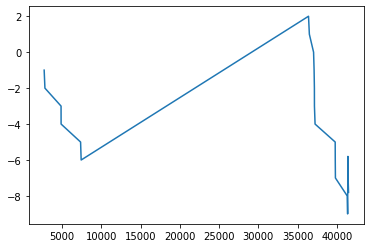

INTERNATIONALE
5
                 start_at        horse_name  race_id     prize  bet  oddsn  \
14960 2019-11-30 15:32:00          ETONNANT    78842  1.425529    1      3   
20635 2019-07-20 17:03:00           DELFINO    73838  2.560373    1      7   
21374 2019-08-10 16:07:00  VIRGIOUS DU MAZA    74755  2.560373    1      8   
21550 2019-08-13 17:21:00    VALOKAJA HINDO    74847  2.977762    1      3   
23330 2018-11-04 15:32:00  ALAMO DU GOUTIER    20861  1.102680    1      8   

         sub_category  final_odds  winner_dividend  placed_dividend  position  \
14960  INTERNATIONALE         9.9              0.0              0.0       8.0   
20635  INTERNATIONALE        26.0              0.0              0.0       8.0   
21374  INTERNATIONALE        38.0              0.0              0.0      20.0   
21550  INTERNATIONALE        17.0           1700.0            200.0       1.0   
23330  INTERNATIONALE        26.0              0.0              0.0       7.0   

       bet  profit  stash  

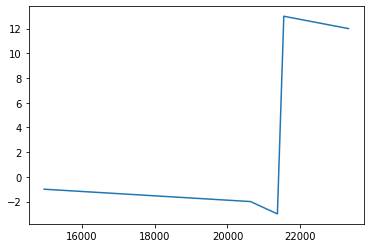

APPRENTIS_LADS_JOCKEYS_EUROPEENNE
4
                 start_at          horse_name  race_id     prize  bet  oddsn  \
19281 2019-03-26 17:34:00   VICTOIRE DE COSSE    69470  1.457669    1      9   
22479 2019-10-21 15:00:00  CIROCO D'AUVILLIER    77350  1.520063    1      3   
31392 2018-07-09 12:25:00      BARBIE PERRINE    22236  0.290040    1      1   
31983 2019-02-20 19:34:00      BAHIA DE LIGNY    68244  0.151621    1      0   

                            sub_category  final_odds  winner_dividend  \
19281  APPRENTIS_LADS_JOCKEYS_EUROPEENNE        48.5              0.0   
22479  APPRENTIS_LADS_JOCKEYS_EUROPEENNE        12.0              0.0   
31392  APPRENTIS_LADS_JOCKEYS_EUROPEENNE         3.2              0.0   
31983  APPRENTIS_LADS_JOCKEYS_EUROPEENNE         3.6            360.0   

       placed_dividend  position  bet  profit  stash  
19281            940.0       2.0    1    -1.0   -1.0  
22479              0.0       6.0    1    -1.0   -2.0  
31392              0.0      20.0

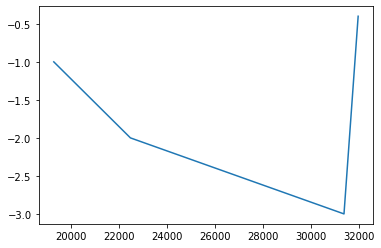

APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART
5
                 start_at         horse_name  race_id     prize  bet  oddsn  \
16632 2018-07-26 13:25:00         UNO DANCER    23020  0.000000    1      9   
17920 2018-08-16 14:05:00  BOLIDE DE LA COTE    62336  0.000000    1      0   
18562 2018-10-18 19:05:00    ULTIMO DU DOUET    65298  0.000000    1      7   
19653 2019-04-29 19:22:00       DREAM TURGOT    70705 -0.167608    1      9   
20779 2019-07-25 19:17:00      VERSO DU JAAR    74058 -0.167608    1      8   

                                      sub_category  final_odds  \
16632  APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART        32.1   
17920  APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART         3.0   
18562  APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART        16.1   
19653  APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART        36.0   
20779  APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART        38.0   

       winner_dividend  placed_dividend  position  bet  profit  stash  
16632     

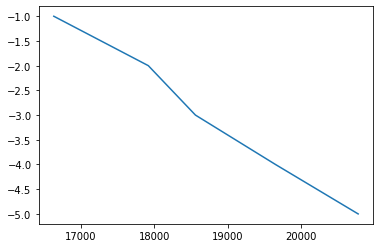

A_RECLAMER_APPRENTIS_LADS_JOCKEYS
5
                 start_at          horse_name  race_id     prize  bet  oddsn  \
22604 2019-10-23 18:25:00   CARTOUCHE JEMISKA    77440 -0.167608    1      8   
24780 2018-05-27 15:00:00   DRYOPS DU GOUTIER    66831 -1.102640    1     10   
24796 2018-05-27 15:33:00  BOMBO DE CARENTONE    66832 -1.102640    1      8   
30223 2018-01-07 15:48:00      VASCO D'AGAMIS    65945 -1.102640    1     13   
32424 2019-05-24 21:00:00  ARCHE DE MALBERAUX    71678 -1.102640    1      3   

                            sub_category  final_odds  winner_dividend  \
22604  A_RECLAMER_APPRENTIS_LADS_JOCKEYS        29.0              0.0   
24780  A_RECLAMER_APPRENTIS_LADS_JOCKEYS        34.4              0.0   
24796  A_RECLAMER_APPRENTIS_LADS_JOCKEYS        24.0              0.0   
30223  A_RECLAMER_APPRENTIS_LADS_JOCKEYS        47.9              0.0   
32424  A_RECLAMER_APPRENTIS_LADS_JOCKEYS         8.4              0.0   

       placed_dividend  position  bet  profi

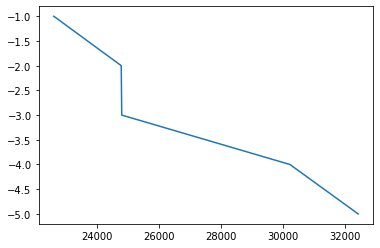

AMATEURS_NATIONALE
2
                 start_at          horse_name  race_id     prize  bet  oddsn  \
12997 2018-04-25 14:20:00        CAIMAN FAWEY    18023 -1.457597    1      9   
42096 2018-03-28 14:52:00  VINGT DEUX JUILLET    16873 -1.457597    1      0   

             sub_category  final_odds  winner_dividend  placed_dividend  \
12997  AMATEURS_NATIONALE        22.5              0.0              0.0   
42096  AMATEURS_NATIONALE         3.7              0.0            170.0   

       position  bet  profit  stash  
12997      20.0    1    -1.0   -1.0  
42096       3.0    1    -1.0   -2.0  


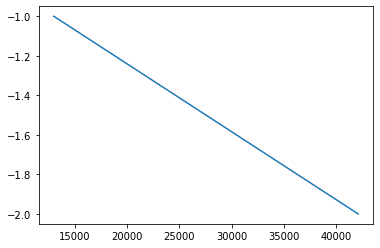

AMATEURS_EUROPEENNE_AUTOSTART
1
                 start_at    horse_name  race_id     prize  bet  oddsn  \
22830 2018-04-28 20:25:00  AZUR DAIRPET    18178 -1.915201    1      3   

                        sub_category  final_odds  winner_dividend  \
22830  AMATEURS_EUROPEENNE_AUTOSTART        13.0            280.0   

       placed_dividend  position  bet  profit  stash  
22830            230.0       1.0    1     1.8    1.8  


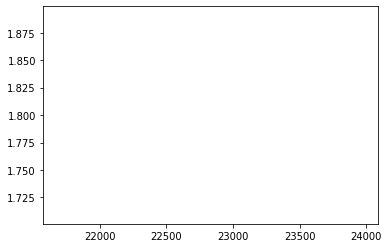

INTERNATIONALE_AUTOSTART
2
                 start_at          horse_name  race_id     prize  bet  oddsn  \
15609 2018-04-21 16:09:00  BILLIE DE MONTFORT    17857  3.663085    1      3   
20936 2019-07-27 16:25:00      DORGOS DE GUEZ    74122  2.560373    1      5   

                   sub_category  final_odds  winner_dividend  placed_dividend  \
15609  INTERNATIONALE_AUTOSTART        24.0              0.0              0.0   
20936  INTERNATIONALE_AUTOSTART        23.0              0.0              0.0   

       position  bet  profit  stash  
15609       4.0    1    -1.0   -1.0  
20936       6.0    1    -1.0   -2.0  


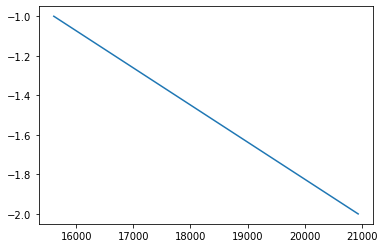

AMATEURS_PRIORITE_AUX_PROPRIETAIRES
1
                 start_at horse_name  race_id     prize  bet  oddsn  \
49128 2018-07-14 20:07:00    BOYARDO    22500 -2.560118    1      4   

                              sub_category  final_odds  winner_dividend  \
49128  AMATEURS_PRIORITE_AUX_PROPRIETAIRES        20.1              0.0   

       placed_dividend  position  bet  profit  stash  
49128              0.0       5.0    1    -1.0   -1.0  


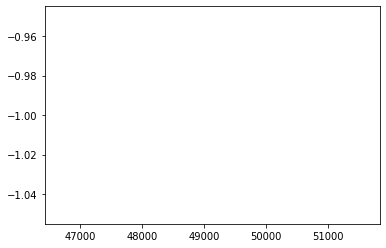

QUALIFICATION_ACCAF
2
                start_at horse_name  race_id     prize  bet  oddsn  \
2844 2018-06-22 14:05:00     DALOOB    20529  1.457669    1      5   
7505 2019-06-21 14:18:00    AL HAZM    72691  1.457669    1      0   

             sub_category  final_odds  winner_dividend  placed_dividend  \
2844  QUALIFICATION_ACCAF        29.8              0.0              0.0   
7505  QUALIFICATION_ACCAF         3.2              0.0            130.0   

      position  bet  profit  stash  
2844       4.0    1    -1.0   -1.0  
7505       2.0    1    -1.0   -2.0  


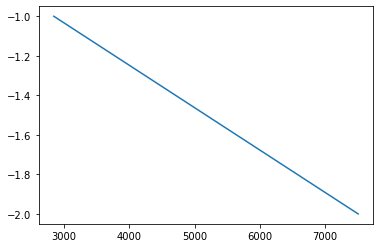

COURSE_AP
1
                 start_at        horse_name  race_id     prize  bet  oddsn  \
42557 2018-04-25 14:00:00  COQUIN DU HOULEY    66569 -0.812614    1      8   

      sub_category  final_odds  winner_dividend  placed_dividend  position  \
42557    COURSE_AP        26.5              0.0              0.0      20.0   

       bet  profit  stash  
42557    1    -1.0   -1.0  


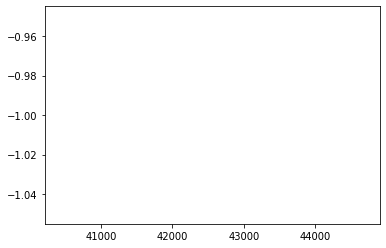

A_RECLAMER_AMATEURS_AUTOSTART
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


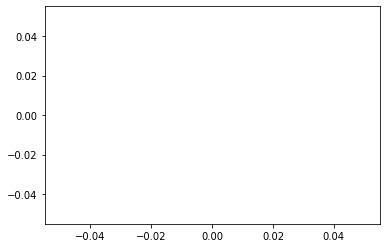

A_RECLAMER_AMATEURS
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


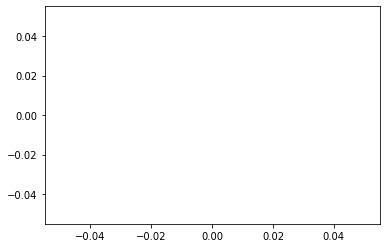

COURSE_INTERNATIONALE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


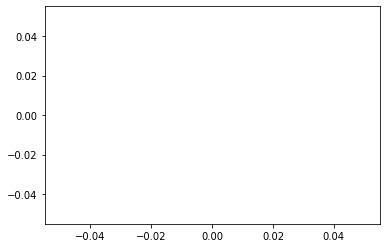

FINALE_REGIONALE_ACCAF
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


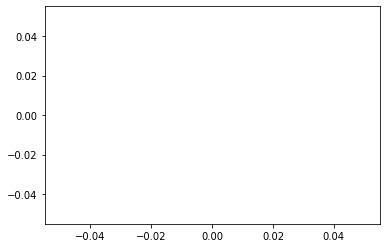

AMATEURS_INTERNATIONALE_AUTOSTART
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


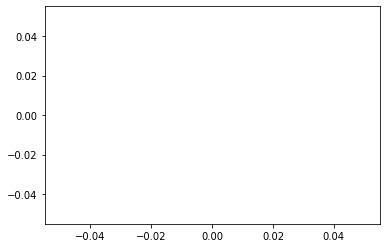

AMATEURS_INTERNATIONALE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


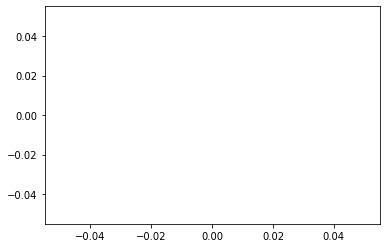

HANDICAP_A_RECLAMER
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


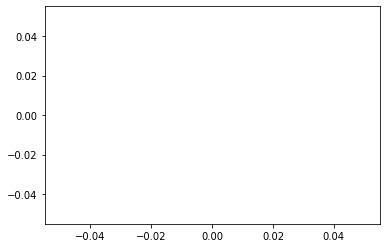

AMATEURS_EUROPEENNE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


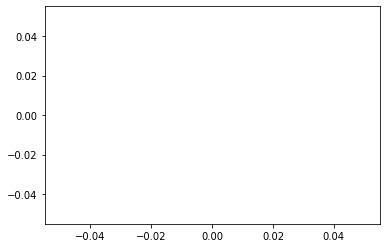

AMATEURS_DAMES_AUTOSTART
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


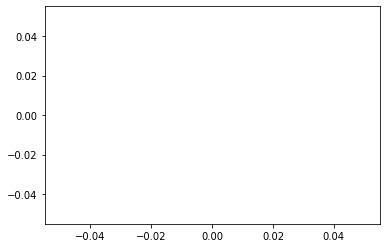

MIXTE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


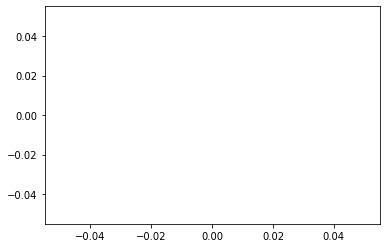

COURSE_AP_EUROPEENNE
0
Empty DataFrame
Columns: [start_at, horse_name, race_id, prize, bet, oddsn, sub_category, final_odds, winner_dividend, placed_dividend, position, bet, profit, stash]
Index: []


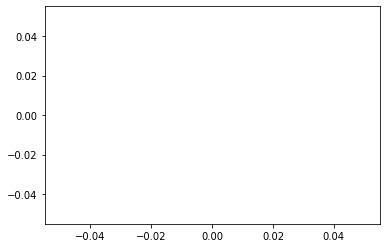

In [343]:
from matplotlib import pyplot as plt
for cat in df_test['sub_category'].value_counts().index:
    print(cat)
    #g = df_test[ (df_test['pn']==0) & (df_test['sub_category']==cat) & (df_test['final_odds'] > 8) ].copy()
    #g = df_test[ (df_test['pn']<df_test['oddsn']) & (df_test['sub_category']==cat) & (df_test['final_odds_ref_real'] > 20) ].copy()
    g = df_test[ (df_test['pn_diff']>5) & (df_test['pn']==0) & (df_test['sub_category']==cat) & (df_test['final_odds_ref_real'] > 2) & (df_test['final_odds_ref_real'] < 40) ].copy()
    
    #g = g.groupby('race_id').apply(lambda r: r.iloc[-3:])
    
    g['stash'] = g['profit'].cumsum()
    pd.set_option('display.max_rows', 1000)
    print(len(g))
    print(g[['start_at', 'horse_name', 'race_id', 'prize', 'bet', 'oddsn', 'sub_category', 'final_odds', 'winner_dividend', 'placed_dividend', 'position', 'bet', 'profit', 'stash']].head(10))
    g['stash'].plot()
    plt.show()

In [ ]:
g['stash'].plot()

In [ ]:
from dill import dump, load

dump(scaler, open('/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos2/scaler.pkl', 'wb+'))

model.save('/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos2/model.h5')

In [ ]:
dump(horse_dummies, open('/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos2/horse_dummies.pkl', 'wb'))
dump(race_dummies, open('/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos2/race_dummies.pkl', 'wb'))